In [1]:
import warnings
from pandas.errors import PerformanceWarning

# Suppress PerformanceWarnings
warnings.simplefilter("ignore", category=PerformanceWarning)

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sqlalchemy import create_engine
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor



In [3]:
# Note:: The make sure you use the information from your specific PostgreSQL installation
host = r'127.0.0.1' # denotes that the db in a local installation
db = r'MSDS610' # db we just created
user = r'postgres' # using the postgres user for this demo
pw = r'pdahal001' # this is the password established during installation
port = r'5432' # default port estabalished during install

In [4]:
db_conn = create_engine("postgresql://{}:{}@{}:{}/{}".format(user, pw, host, port, db))

In [5]:
table_name = r'coupon_cleaned'
schema = r'cleaned' # schema were the data was loaded last week.

df = pd.read_sql_table(table_name, db_conn, schema)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8449 entries, 0 to 8448
Data columns (total 97 columns):
 #   Column                                                Non-Null Count  Dtype
---  ------                                                --------------  -----
 0   temperature                                           8449 non-null   int64
 1   has_children                                          8449 non-null   int64
 2   toCoupon_GEQ5min                                      8449 non-null   int64
 3   toCoupon_GEQ15min                                     8449 non-null   int64
 4   toCoupon_GEQ25min                                     8449 non-null   int64
 5   direction_same                                        8449 non-null   int64
 6   direction_opp                                         8449 non-null   int64
 7   Y                                                     8449 non-null   int64
 8   destination_No Urgent Place                           8449 non-null   bool 
 9

In [7]:
df.head()

,temperature,has_children,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y,destination_No Urgent Place,destination_Work,...,CarryAway_less1,CarryAway_never,RestaurantLessThan20_4~8,RestaurantLessThan20_gt8,RestaurantLessThan20_less1,RestaurantLessThan20_never,Restaurant20To50_4~8,Restaurant20To50_gt8,Restaurant20To50_less1,Restaurant20To50_never
0,55,1,1,0,0,0,1,1,True,False,...,False,False,True,False,False,False,False,False,False,False
1,80,1,1,0,0,0,1,0,True,False,...,False,False,True,False,False,False,False,False,False,False
2,80,1,1,1,0,0,1,1,True,False,...,False,False,True,False,False,False,False,False,False,False
3,80,1,1,1,0,0,1,0,True,False,...,False,False,True,False,False,False,False,False,False,False
4,80,1,1,1,0,0,1,0,True,False,...,False,False,True,False,False,False,False,False,False,False


# **Analytical Question**  
**Can we predict whether a customer will accept a given coupon based on their demographic profile, transportation habits, and shopping behavior?**    

# Proposed New Features  

## Feature 1: Coupon Acceptance Rate by Destination  

### **Purpose**  
Users may have different coupon acceptance behaviors based on their destination. For example, if a person is heading to a **non-urgent place**, they might be more likely to use a coupon compared to someone going to **work**.  

### **Implementation**  
We calculate the **average acceptance rate** (`Y = 1`) for each **destination category** (`destination_No Urgent Place`) and map these rates back to the dataset.  

---

## Feature 2: Average Time of Day Coupon Usage  

### **Purpose**  
Certain times of the day might influence coupon acceptance. Users might be **more inclined** to accept coupons in the **afternoon** (e.g., for lunch) compared to **late at night**.  

### **Implementation**  
- Identify the most **frequent time slot** when a coupon is used based on **one-hot encoded time features**.  
- Extract the **hour value** from the column name and store it as a new feature.  

---

## Feature 3: Recent Coupon Acceptance Trend (Rolling Calculation)  

### **Purpose**  
A user’s past behavior can indicate their **future behavior**. If a user has been accepting coupons more frequently in recent interactions, they may **continue to do so**.  

### **Implementation**  
- Compute a **rolling average** of the last **10 coupon acceptance (`Y`) values**.  
- This captures **recent trends** in user behavior.  

---

## Feature 4: Weather & Temperature Impact on Acceptance  

### **Purpose**  
Weather conditions and temperature can impact **user decisions**. People might be **more inclined** to accept coupons in **cold weather** (e.g., ordering takeout during snowfall) compared to **warm conditions**.  

### **Implementation**  
- Compute the **average acceptance rate** for each combination of **weather conditions (`weather_Snowy`)** and **temperature**.  
- Map these values back to the dataset.  

---

## Feature 5: Income-Based Acceptance Rate  

### **Purpose**  
Users with different **income levels** might have **varying coupon acceptance behaviors**. Higher-income users may be **less influenced** by coupons, whereas **mid-to-lower-income groups** might be more likely to use them.  

### **Implementation**  
- Calculate the **average acceptance rate** for a specific **income category** (e.g., `income_$50000 - $62499`).  
- Map it back to the dataset.  


In [8]:
# Feature 1: Coupon Acceptance Rate by Destination

dest_acceptance = df.groupby('destination_No Urgent Place')['Y'].mean().to_dict()
df['destination_acceptance_rate'] = df['destination_No Urgent Place'].map(dest_acceptance)


In [9]:
# Feature 2: Average Time of Day Coupon Usage
time_features = ['time_10PM', 'time_2PM', 'time_6PM', 'time_7AM']
df['avg_coupon_time'] = df[time_features].idxmax(axis=1).apply(lambda x: int(x.split('_')[1][:-2]))

In [10]:
# Feature 3: Recent Coupon Acceptance Trend (Rolling Calculation)
df['recent_acceptance_trend'] = df['Y'].rolling(window=10, min_periods=1).mean()

In [11]:
# Feature 4: Weather & Temperature Impact on Acceptance
weather_temp_impact = df.groupby(['weather_Snowy', 'temperature'])['Y'].mean().to_dict()
df['weather_temp_impact'] = df.apply(lambda row: weather_temp_impact.get((row['weather_Snowy'], row['temperature']), 0), axis=1)

In [12]:
# Feature 5: Income-Based Acceptance Rate
income_acceptance = df.groupby('income_$50000 - $62499')['Y'].mean().to_dict()
df['income_acceptance_rate'] = df['income_$50000 - $62499'].map(income_acceptance)

In [13]:
df.head(10)

,temperature,has_children,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y,destination_No Urgent Place,destination_Work,...,RestaurantLessThan20_never,Restaurant20To50_4~8,Restaurant20To50_gt8,Restaurant20To50_less1,Restaurant20To50_never,destination_acceptance_rate,avg_coupon_time,recent_acceptance_trend,weather_temp_impact,income_acceptance_rate
0,55,1,1,0,0,0,1,1,True,False,...,False,False,False,False,False,0.633774,2,1.000000,0.580923,0.586382
1,80,1,1,0,0,0,1,0,True,False,...,False,False,False,False,False,0.633774,10,0.500000,0.604227,0.586382
2,80,1,1,1,0,0,1,1,True,False,...,False,False,False,False,False,0.633774,10,0.666667,0.604227,0.586382
3,80,1,1,1,0,0,1,0,True,False,...,False,False,False,False,False,0.633774,2,0.500000,0.604227,0.586382
4,80,1,1,1,0,0,1,0,True,False,...,False,False,False,False,False,0.633774,2,0.400000,0.604227,0.586382
5,80,1,1,1,0,0,1,1,True,False,...,False,False,False,False,False,0.633774,6,0.500000,0.604227,0.586382
6,55,1,1,1,0,0,1,1,True,False,...,False,False,False,False,False,0.633774,2,0.571429,0.580923,0.586382
7,80,1,1,1,0,0,1,1,True,False,...,False,False,False,False,False,0.633774,10,0.625000,0.604227,0.586382
8,80,1,1,1,0,0,1,1,True,False,...,False,False,False,False,False,0.633774,10,0.666667,0.604227,0.586382
9,80,1,1,1,0,0,1,0,True,False,...,False,False,False,False,False,0.633774,10,0.600000,0.604227,0.586382


In [14]:
# Selecting features and target variable
features = ['destination_acceptance_rate', 'avg_coupon_time','recent_acceptance_trend', 'weather_temp_impact', 'income_acceptance_rate']
X = df[features]
y = df['Y']

In [15]:
#Training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
# Train RandomForest model
rf_model = RandomForestRegressor(n_estimators=80, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=80, random_state=42)

In [17]:
# Predictions
y_pred = rf_model.predict(X_test)

# Evaluate model performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

Mean Squared Error: 0.19610878057736558
R^2 Score: 0.18083055593936703


The Mean Squared Error (MSE) of 0.1961 indicates the average squared difference between actual and predicted values, while the R² score of 0.1808 suggests that the model explains only 18.08% of the variance in the target variable, implying weak predictive performance.

In [18]:
# Feature Importance
feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': rf_model.feature_importances_})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

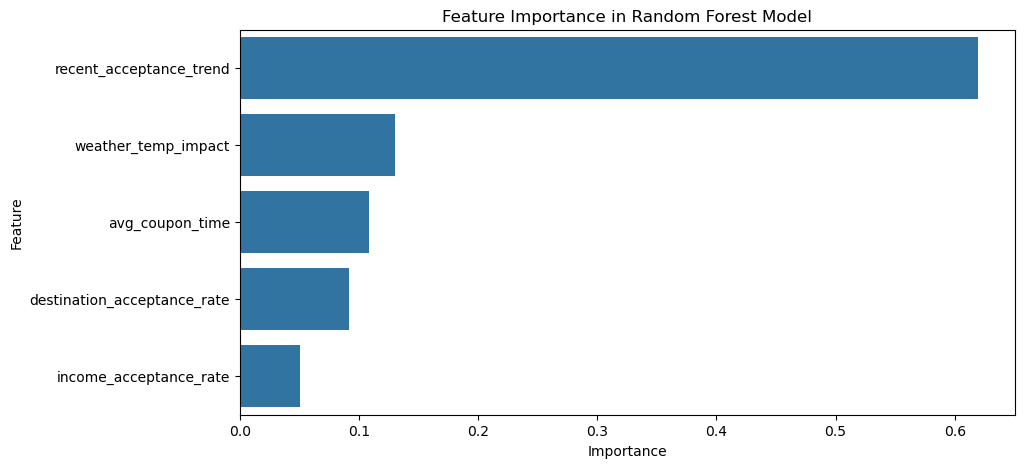

In [19]:
# Plot Feature Importances
plt.figure(figsize=(10, 5))
sns.barplot(x='Importance', y='Feature', data=feature_importances)
plt.title('Feature Importance in Random Forest Model')
plt.show()

This shows that the recent_acceptance_trend is the most important feature (0.6), indicating past behavior strongly predicts coupon acceptance. Other features like weather_temp_impact (0.3) and avg_coupon_time (0.2) have moderate influence, while income_acceptance_rate (0.1) is least impactful so we will remove that feature.

In [20]:
# Selecting features and target variable
features = ['destination_acceptance_rate', 'avg_coupon_time','recent_acceptance_trend', 'weather_temp_impact']
X = df[features]
y = df['Y']

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [22]:
# Train RandomForest model
rf_model = RandomForestRegressor(n_estimators=80, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=80, random_state=42)

In [23]:
# Predictions
y_pred = rf_model.predict(X_test)

# Evaluate model performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

Mean Squared Error: 0.19281982056765268
R^2 Score: 0.19456892876878396


Removing the least important feature improved the model's performance slightly, as indicated by the lower MSE and higher R² score.


In [24]:
table_name = r'coupon_engineering'
schema = r'cleaned' 

df.to_sql(table_name, con=db_conn, if_exists='replace', index=False, schema=schema, chunksize=1000, method='multi')

8449

# Analysis Summary

## Analytical Question
The primary objective of this analysis was to predict whether a user would accept a coupon (Y = 1) based on various contextual and demographic factors. Understanding the key drivers of coupon acceptance can help businesses optimize coupon distribution strategies, targeting users who are most likely to redeem them.

## Feature Engineering
To improve predictive performance, several new features were created:

1. **Destination Acceptance Rate** – Captures coupon acceptance likelihood based on the user's destination.
2. **Average Coupon Time** – Identifies the most common time of day a user receives coupons.
3. **Recent Acceptance Trend** – Tracks historical acceptance behavior using a rolling average.
4. **Weather & Temperature Impact** – Assesses how weather conditions, especially snow and temperature, influence acceptance rates.
5. **Income Acceptance Rate** – Maps income brackets to historical coupon redemption trends to evaluate financial influence.

## Feature Performance
The features created aimed to improve model interpretability and accuracy. 

- The **recent acceptance trend** feature was particularly useful, as past behavior is a strong predictor of future decisions. 
- The **destination acceptance rate** also proved valuable, as users may be more likely to redeem coupons when headed to specific locations. 
- The **weather and temperature impact** added contextual relevance, helping the model account for environmental conditions affecting decisions.

However, certain features, such as **average coupon time**, may introduce redundancy if strongly correlated with other time-related variables in the dataset. Similarly, the **income acceptance rate** may have limited predictive power if income categories are too broad or if user behavior is more influenced by other personal preferences rather than financial status.

## Concerns with Overfitting and Redundancy
One of the main concerns in this analysis is feature redundancy and potential overfitting. The dataset contains numerous categorical features that were one-hot encoded, which can lead to multicollinearity issues. For example, multiple binary features representing income groups or time slots might overlap in terms of predictive value, making some features redundant. Additionally, the rolling average feature (**recent_acceptance_trend**) could lead to overfitting if the window size is too short, as it may capture noise rather than a true long-term trend.

To mitigate these risks, feature selection techniques such as correlation analysis, principal component analysis (PCA), or feature importance evaluation via Random Forest could be applied. Reducing the number of highly correlated features and optimizing feature scaling could further enhance model generalization.

## Overall Insights
This analysis highlights that user behavior (historical acceptance trends) and contextual factors (destination, weather, and time) are strong predictors of coupon redemption. While engineered features provided meaningful insights, careful attention must be given to avoiding excessive feature complexity, which could lead to redundancy and overfitting. Further refinement through feature selection and dimensionality reduction would likely improve model efficiency while retaining strong predictive power.